In [21]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [22]:
# Load the data
dataset = pickle.load(open('data/ocr_insurance_dataset.pkl', 'rb'))

In [23]:
# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

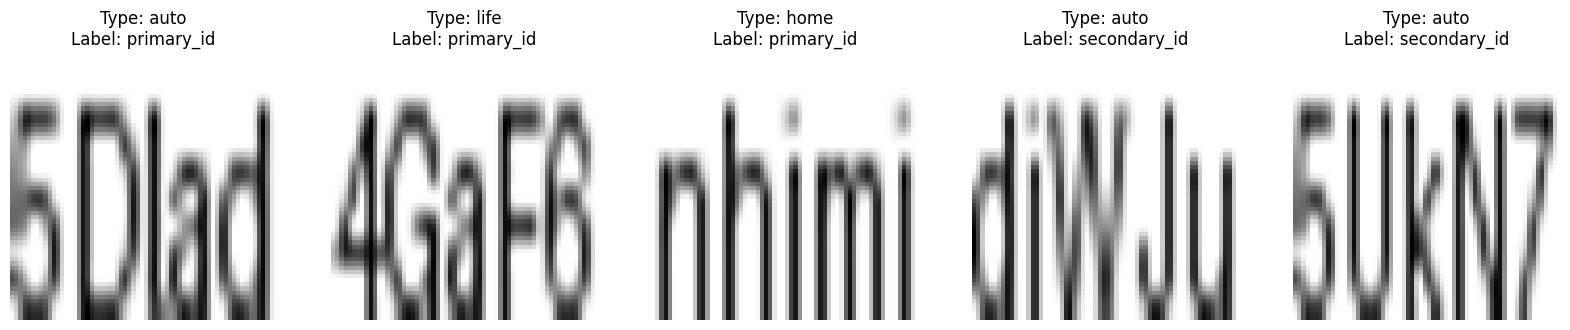

In [24]:
# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [25]:
#create the ocr model

class OCRModel(nn.Module):
    def __init__(self, num_insurance_types=5):
        super(OCRModel, self).__init__()

        #Image processing layers
        self.image_layer = nn.Sequential(nn.Con2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),nn.Flatten())

In [26]:
# Write a class to define the model's structure
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)  
        )
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 64), 
            nn.ReLU(),
            nn.Linear(64, 2)  
        )
        
    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image, x_type), dim=1)  
        return self.classifier(x)

# Load the data in batches
train_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Call the model
model = OCRModel()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train for ten epochs
for epoch in range(10):  
    for (images, types), labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images, types)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.8958733677864075
Epoch 2, Loss: 0.6495752334594727
Epoch 3, Loss: 0.9637743234634399
Epoch 4, Loss: 0.5603922009468079
Epoch 5, Loss: 0.5453170537948608
Epoch 6, Loss: 0.3291184902191162
Epoch 7, Loss: 0.29743799567222595
Epoch 8, Loss: 0.33805903792381287
Epoch 9, Loss: 0.2962632179260254
Epoch 10, Loss: 0.3015774190425873
